# Learning Curve Example with GPU and Mini-Batch Gradient Descent

This is an example of a learning curve for a Pytorch model that is trained using mini-batch gradient descent and GPU processing.  The data is the [MNIST data set](http://yann.lecun.com/exdb/mnist/).

In [ ]:
!pip list

In [1]:
# Packages to install on Google Colab
!pip install --upgrade skorch scikit-learn # need scikit-learn v1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [29]:
import numpy as np
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, make_scorer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from skorch import NeuralNetClassifier

In [3]:
train_data = torchvision.datasets.MNIST('.',train=True, download=True)
test_data = torchvision.datasets.MNIST('.',train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [17]:
X_train = train_data.data.view(-1,28*28).detach().numpy().astype(np.float32) / 255
X_test = test_data.data.view(-1,28*28).detach().numpy().astype(np.float32) / 255
X = np.vstack((X_train,X_test))

In [18]:
y_train = train_data.targets.detach().numpy().astype(np.int64)
y_test = test_data.targets.detach().numpy().astype(np.int64)
y = np.concatenate((y_train, y_test))

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [9]:
class ClassifierModule(nn.Module):
    def __init__(self, num_units=150):
        super().__init__()
        self.dense0 = nn.Linear(28*28, num_units)
        self.nonlin = nn.ReLU()
        self.output = nn.Linear(num_units,10)

    def forward(self, X, **kwargs):
        X = self.dense0(X)
        X = self.nonlin(X)
        X = self.output(X)
        return X

In [30]:
net = NeuralNetClassifier(
    ClassifierModule,
    module__num_units=128,
    max_epochs=10,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    device=device,
    batch_size=128,
    warm_start=True,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True
)

In the learing curves below, the test and training metrics level off towards the right of the plot.  This suggests more training data would not improve model performance.

Since the training accuracy is high, the model is unlikely to suffer from high bias.  There is a noticeable gap between the two curves towards the right of the plot.  If the desired test accuracy is 98%, then this plot suggests that the variance of this model is too high.  In fact, 98% accuracy is achievable with a convolutional neural network model (See the [skorch MNIST tutorial](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb)).

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6885       0.8420        0.5671  0.1121
      2        0.2713       0.8821        0.4163  0.1116
      3        0.1667       0.8946        0.3618  0.1154
      4        0.0892       0.9143        0.3178  0.1059
      5        0.0602       0.9027        0.3733  0.1198
      6        0.0429       0.9045        0.3779  0.1107
      7        0.0274       0.9045        0.4036  0.1052
      8        0.0222       0.9161        0.4096  0.1151
      9        0.0120       0.9116        0.3998  0.1055
     10        0.0068       0.9170        0.4271  0.1065
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4020       0.9286        0.2337  0.3405
      2        0.1620       0.9426        0.1873  0.3407
      3        0.1029       0.9478        0.1646  0.3458
      4        0.0713       0.9

Text(0.5, 1.0, 'Learning Curve')

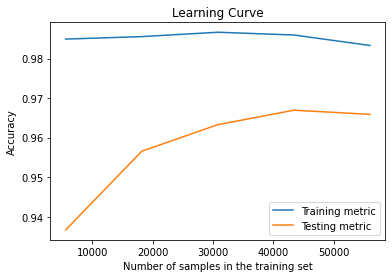

In [31]:
lcd = LearningCurveDisplay.from_estimator(net, X, y, score_type='both', 
                std_display_style=None, score_name='Accuracy', 
    scoring=make_scorer(accuracy_score))
lcd.ax_.set_title('Learning Curve')